In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from joblib import dump
from dynaconf import settings
import pyodbc
import logging
from joblib import Memory
from train_and_pred import *

In [2]:
df_nmi_test_X = None
df_nmi_test_y = None

def load_data(nmi_id, start_date, end_date, facts=[], test_dates=[]):
    global df_nmi_test_X, df_nmi_test_y
    df_nmi_X, df_nmi_Y = get_train_test_data(nmi_id, start_date, end_date)
    df_nmi_test_X, df_nmi_train_X, df_nmi_test_y, df_nmi_train_y = train_test_split(df_nmi_X, df_nmi_Y, test_dates)
    df_nmi_train_X, df_nmi_test_X, df_future, df_LLM, codes = integrate_domain_knowledge(nmi_id, start_date, end_date, df_nmi_train_X, df_nmi_test_X, facts)
    df_nmi_train_X, df_nmi_test_X, df_nmi_train_y, df_nmi_test_y = prep_train_test_data(df_nmi_train_X, df_nmi_test_X, df_nmi_train_y, df_nmi_test_y)
    model, rmse_train, mape_train = train_model(df_nmi_train_X, df_nmi_train_y, nmi_id)
    df_nmi_test_y_pred, rmse_test, mape_test = predict_model(model, df_nmi_test_X, df_nmi_test_y)   
    df_future_dates, y_pred = forecast_nmi_consumption(model, nmi_id, start_date, end_date, df_future, codes)

    return model, mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, df_LLM, df_future

def get_all_meter_details():
    df_meter_info = get_meter_info()
    meter_dict = {row['NetworkID'] : row['Name'] for _, row in df_meter_info.iterrows()}
    campus_dict = {row['NetworkID'] : row['CampusKey'] for _, row in df_meter_info.iterrows()}
    return meter_dict, campus_dict

In [3]:
df_meter_info = get_meter_info()
meter_dict = {row['NetworkID'] : row['Name'] for _, row in df_meter_info.iterrows()}

c:\Users\21361535\OneDrive - LA TROBE UNIVERSITY\PhD\LEAP\BaselineLLM\train_and_pred.py:214: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_out = pd.merge(temp_range, reading_temperature, how="left", left_on="Timestamp", right_on="Timestamp").fillna(


Model loaded from cache


c:\Users\21361535\OneDrive - LA TROBE UNIVERSITY\PhD\LEAP\BaselineLLM\train_and_pred.py:214: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_out = pd.merge(temp_range, reading_temperature, how="left", left_on="Timestamp", right_on="Timestamp").fillna(


Model loaded from cache


c:\Users\21361535\OneDrive - LA TROBE UNIVERSITY\PhD\LEAP\BaselineLLM\train_and_pred.py:214: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_out = pd.merge(temp_range, reading_temperature, how="left", left_on="Timestamp", right_on="Timestamp").fillna(
c:\Users\21361535\OneDrive - LA TROBE UNIVERSITY\PhD\LEAP\BaselineLLM\train_and_pred.py:214: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_out = pd.merge(temp_range, reading_temperature, how="left", left_on="Timestamp", right_on="Timestamp").fillna(
c:\Users\21361535\OneDrive - LA TROBE UNIVERSITY\PhD\LEAP\BaselineLLM\train_and_pred.py:214: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_out = pd.merge(temp_range, reading_temperature, how="left", left_on="T

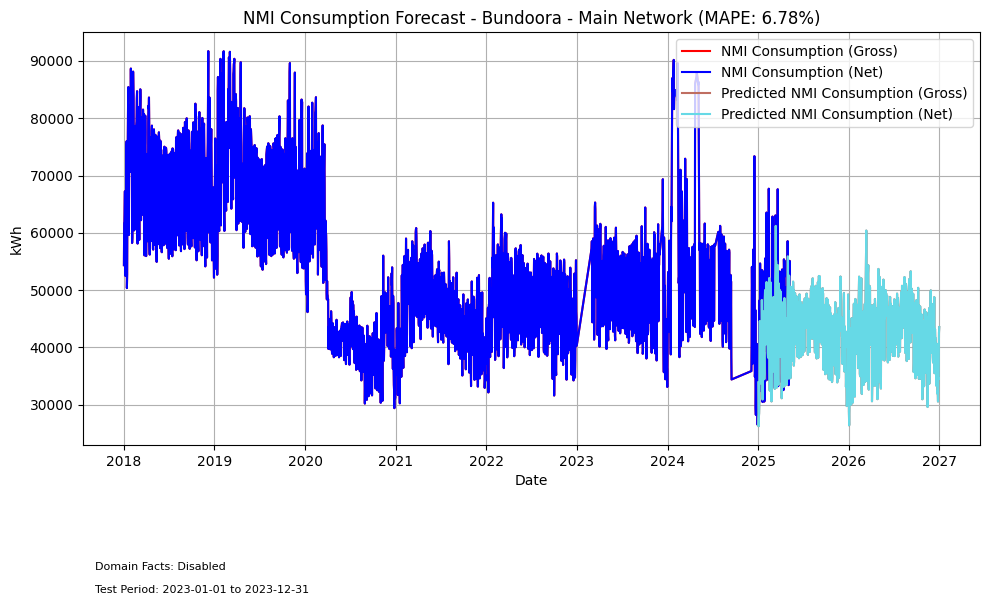

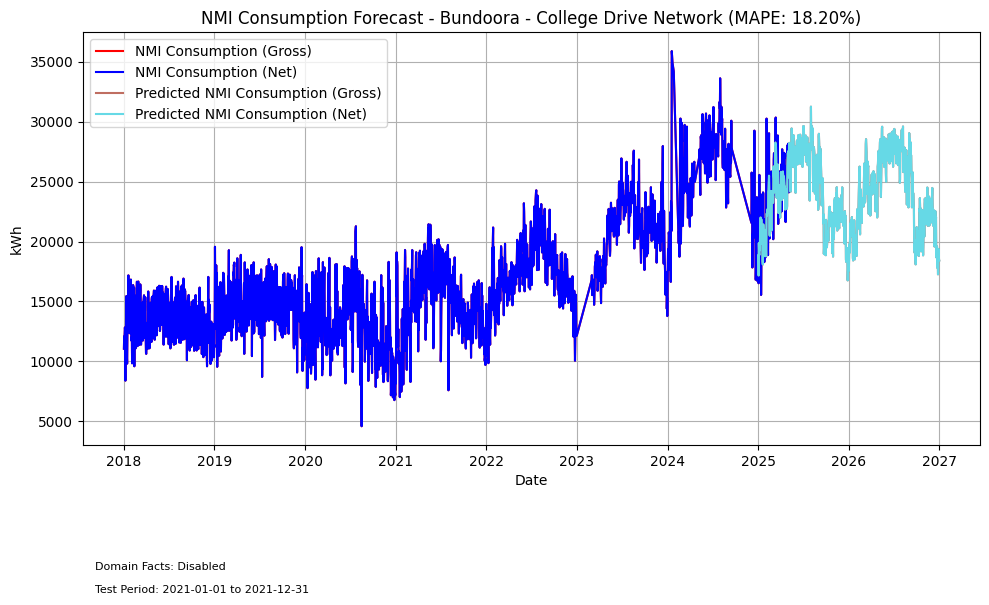

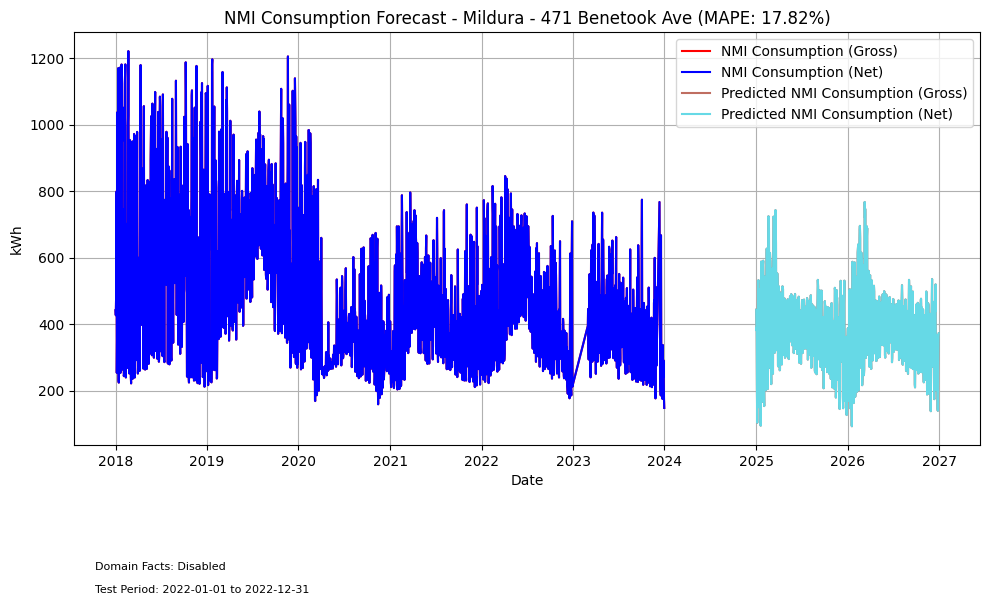

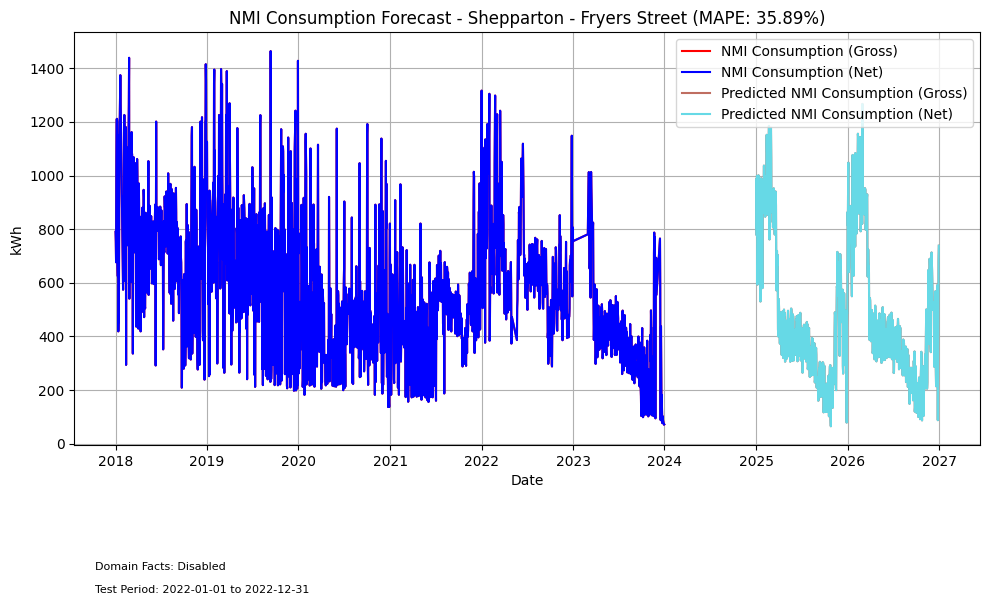

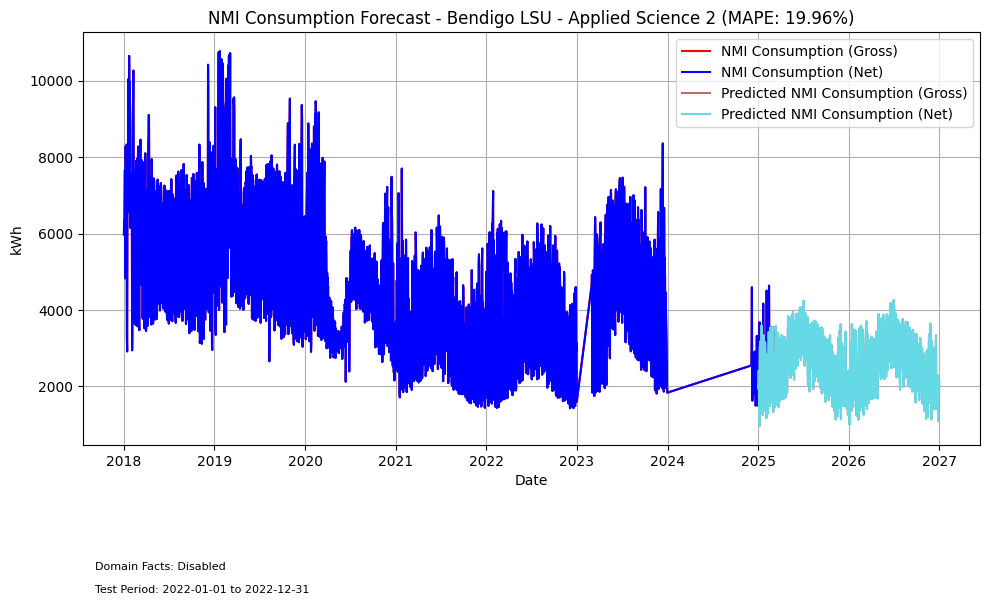

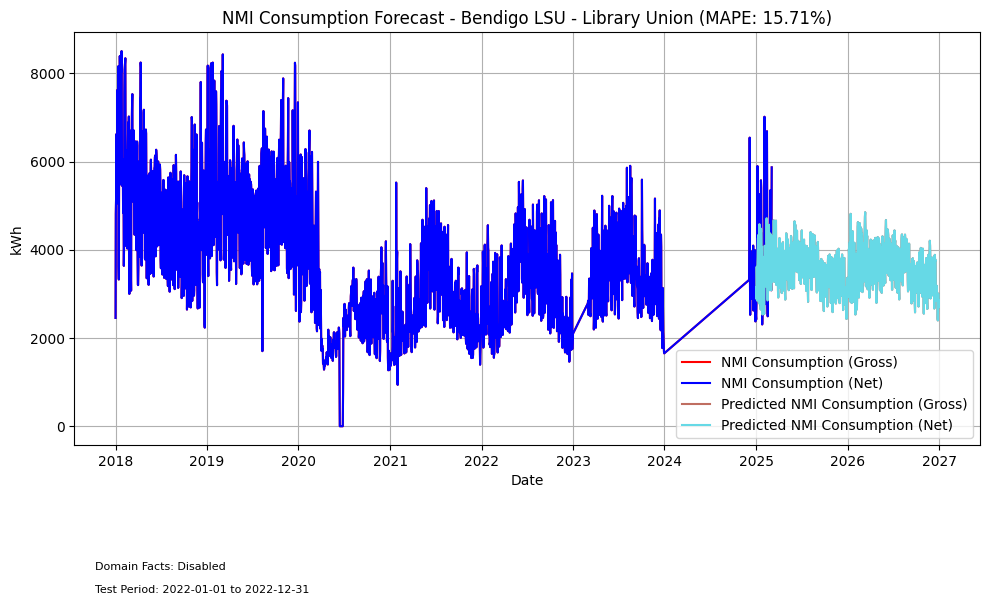

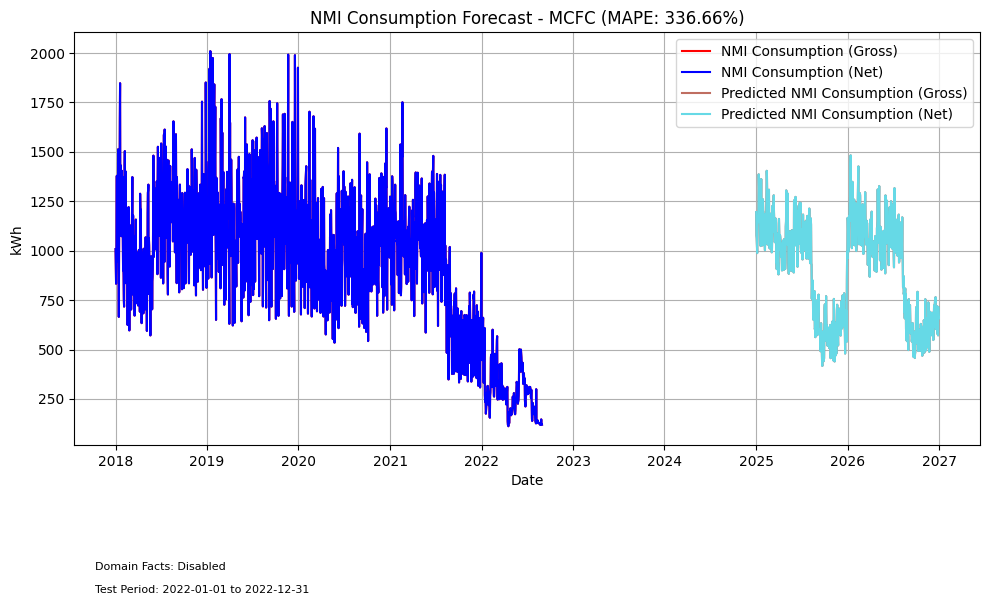

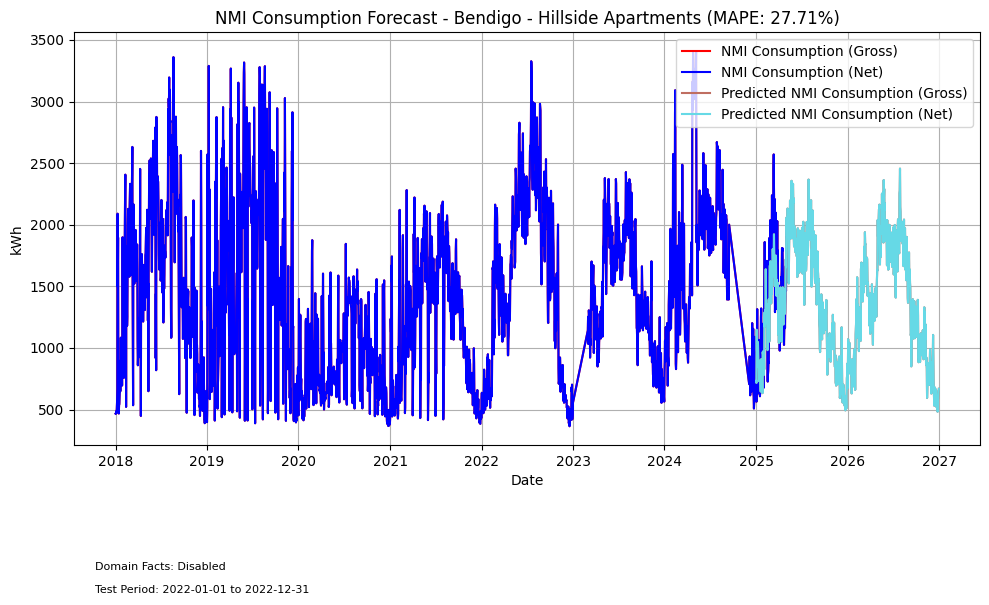

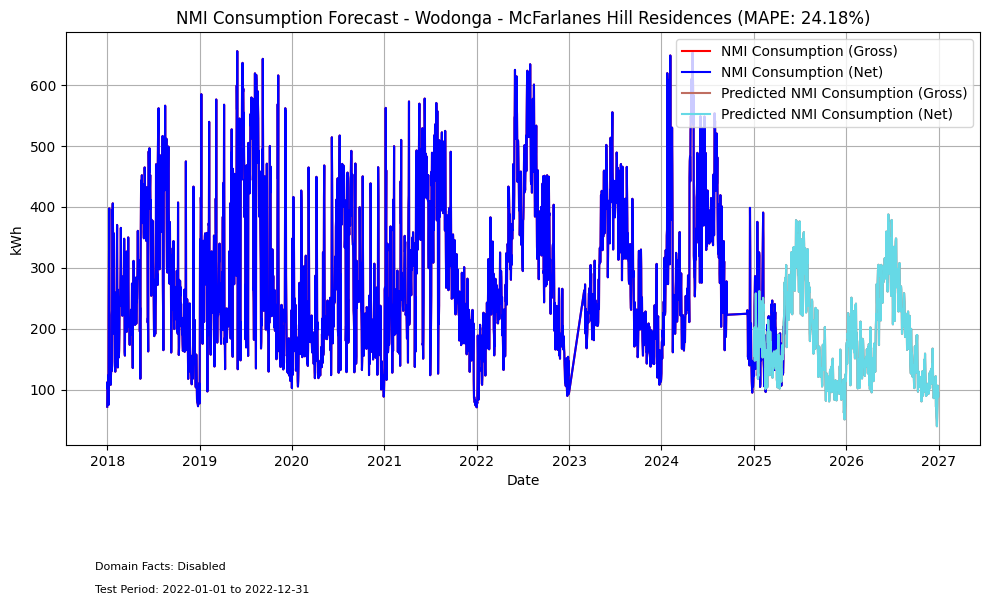

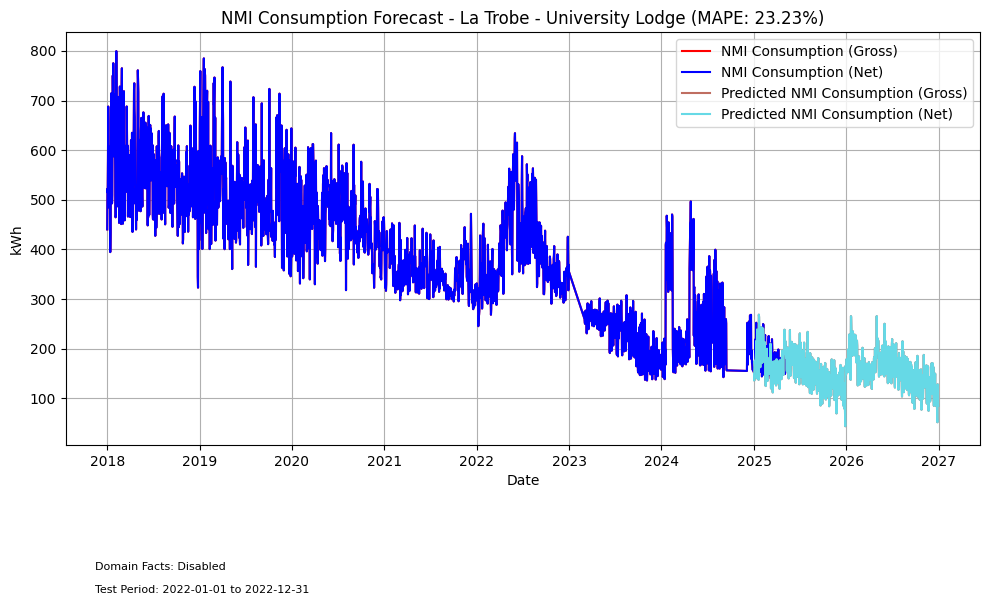

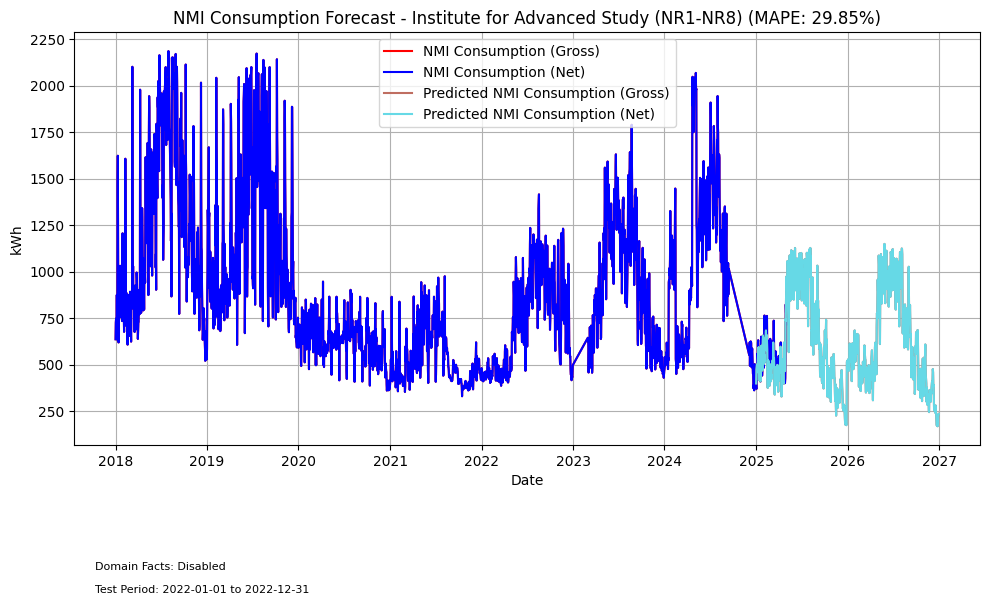

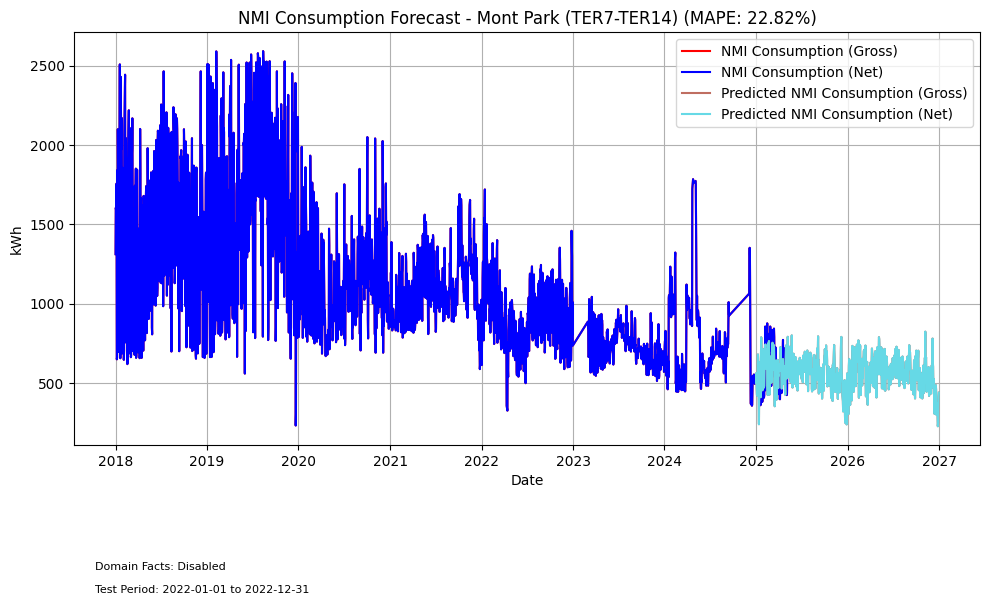

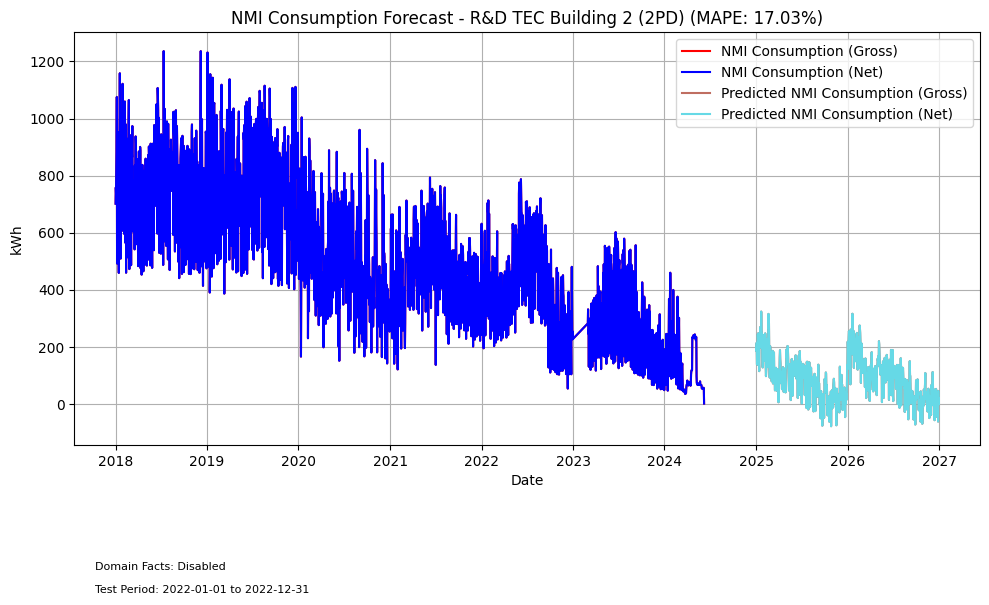

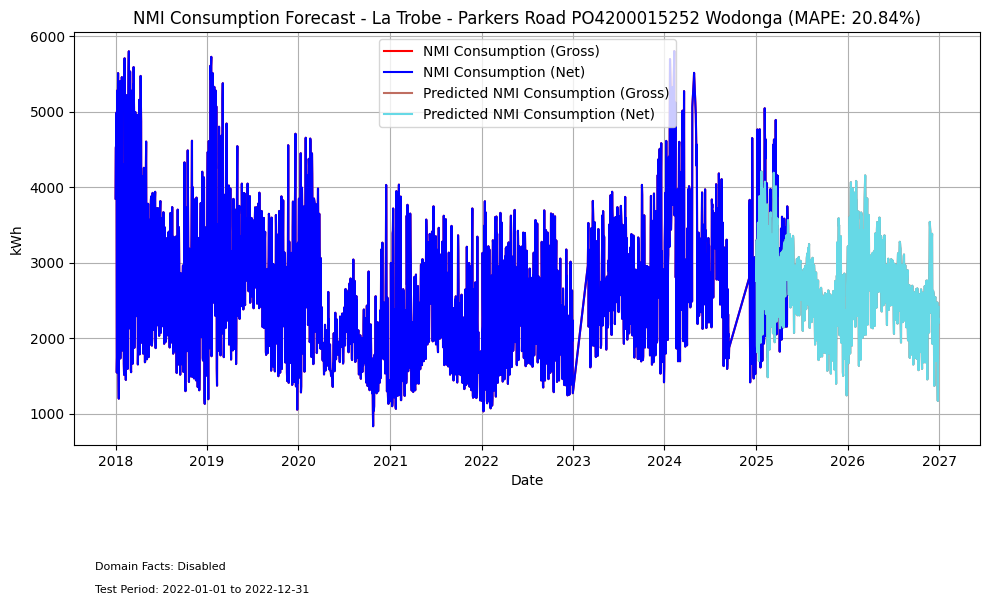

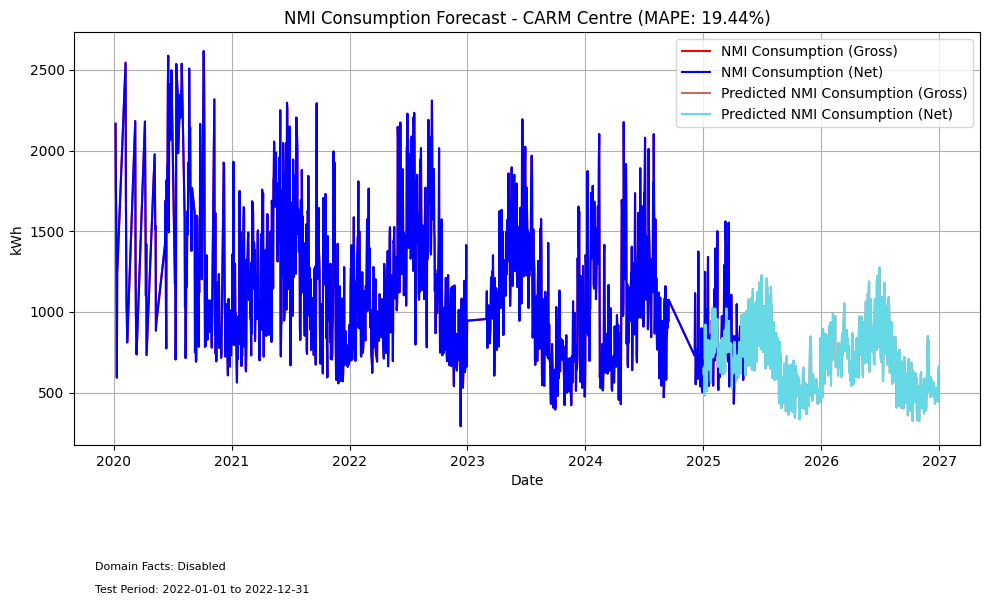

In [4]:
import json
import matplotlib.pyplot as plt

with open('metadata/facts.json', 'r') as f:
    facts_data = json.load(f)

with open('metadata/train_test_split.json', 'r') as f:
    test_split_data = json.load(f)


USE_FACTS = False

for nmi_id, nmi_name in meter_dict.items():
# for i in range(1,2):
    # nmi_id = 107
    start_date = '20180101'
    end_date   = '20250601'

    # Get facts for the current campus
    facts = facts_data.get(str(nmi_id), [])
    test_split = test_split_data.get(str(nmi_id), {})
    
    if USE_FACTS:
        model, mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, df_LLM, df_LLM_future = load_data(nmi_id, start_date, end_date, facts=facts, test_dates=test_split)
    else:
        model, mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, _, _ = load_data(nmi_id, start_date, end_date, test_dates=test_split)

    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(df_nmi_Y['DatePlot'], df_nmi_Y['consumption'], label='NMI Consumption (Gross)', color='red')
    ax.plot(df_nmi_Y['DatePlot'], df_nmi_Y['metered_consumption'], label='NMI Consumption (Net)', color='blue')
    ax.plot(df_future_dates['DatePlot'], y_pred, label='Predicted NMI Consumption (Gross)', color=(0.75, 0.43, 0.38))
    ax.plot(
        df_future_dates['DatePlot'],
        y_pred ,
        color=(0.4, 0.85, 0.9),
        label='Predicted NMI Consumption (Net)'
    )

    ax.set_title(f"NMI Consumption Forecast - {meter_dict[nmi_id]} (MAPE: {mape_test:.2%})")
    ax.set_xlabel("Date")
    ax.set_ylabel("kWh")
    ax.legend()
    ax.grid(True)

    # Add facts and test dates information at the bottom of the plot
    info_text = ""
    if USE_FACTS and facts:
        info_text += "Domain Facts Applied:\n" + "\n".join([f"• {fact}" for fact in facts])
    else:
        info_text += "Domain Facts: Disabled"

    if test_split:
        test_start = str(test_split.get('test_start_date', ''))
        test_end = str(test_split.get('test_end_date', ''))
        if test_start and test_end:
            # Format dates for display
            test_start_formatted = f"{test_start[:4]}-{test_start[4:6]}-{test_start[6:]}"
            test_end_formatted = f"{test_end[:4]}-{test_end[4:6]}-{test_end[6:]}"
            info_text += f"\n\nTest Period: {test_start_formatted} to {test_end_formatted}"

    plt.figtext(0.1, 0, info_text, fontsize=8, wrap=True, ha='left', va='bottom')
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)



In [5]:
print(df_LLM.columns)
print(df_LLM_future.columns)


NameError: name 'df_LLM' is not defined

In [ ]:
feature = 'YearsSinceStart'
df_LLM['DatePlot'] = pd.to_datetime(df_LLM['DatePlot'])
df_LLM_future['DatePlot'] = pd.to_datetime(df_LLM_future['DatePlot'])
plt.plot(df_LLM['DatePlot'], df_LLM[feature])
plt.plot(df_LLM_future['DatePlot'], df_LLM_future[feature])


KeyError: 'YearsSinceStart'

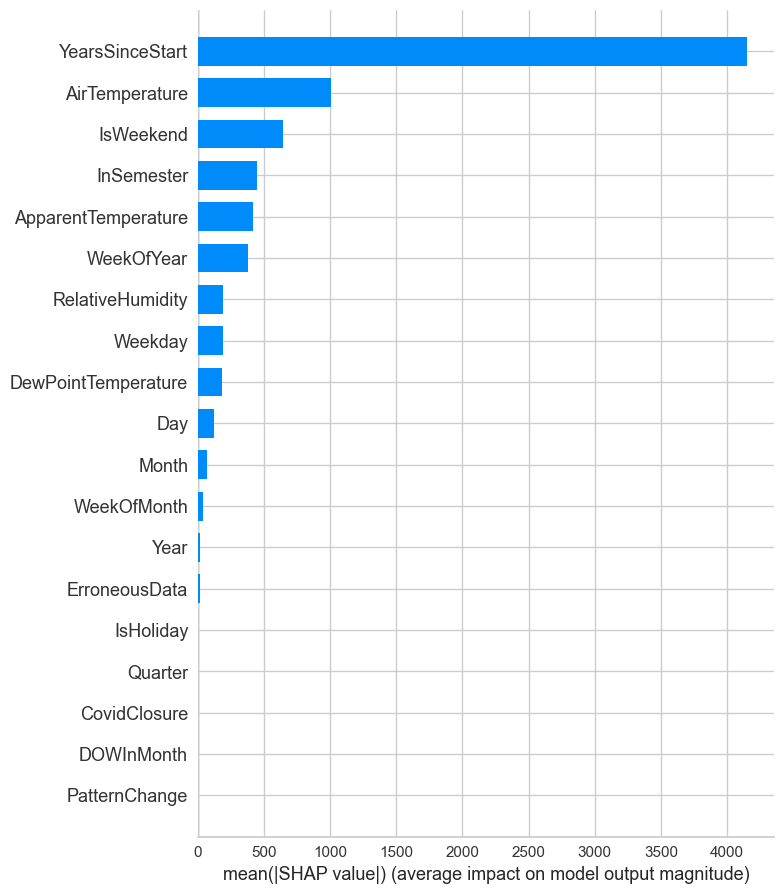

<Figure size 800x550 with 0 Axes>

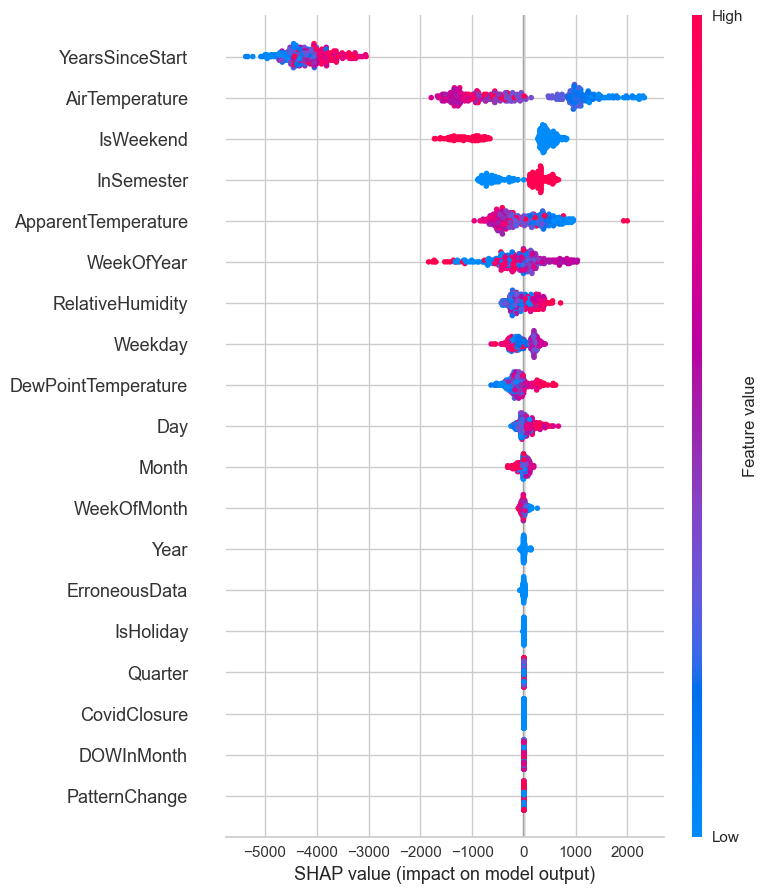

<Figure size 800x550 with 0 Axes>

In [14]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
# X_test = df_LLM[df_LLM['DatePlot'].dt.year == 2022].drop(['DatePlot', 'Consumption'], axis=1)
shap_values = explainer.shap_values(df_nmi_test_X)

# Create beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, df_nmi_test_X, plot_type="bar")
plt.tight_layout()
plt.show()

# Create detailed beeswarm plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, df_nmi_test_X)
plt.tight_layout()
plt.show()
